Installing AutoGluon

In [2]:
!pip3 install -U pip
!pip3 install -U setuptools wheel

# CPU version of pytorch has smaller footprint - see installation instructions in
# pytorch documentation - https://pytorch.org/get-started/locally/
!pip3 install torch==1.12+cpu torchvision==0.13.0+cpu torchtext==0.13.0 -f https://download.pytorch.org/whl/cpu/torch_stable.html

!pip3 install autogluon


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 6.7 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.3 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: h

In [4]:
#tutorial from https://auto.gluon.ai/stable/tutorials/tabular_prediction/tabular-quickstart.html
from autogluon.tabular import TabularDataset, TabularPredictor
train_data = TabularDataset('https://autogluon.s3.amazonaws.com/datasets/Inc/train.csv')
test_data = TabularDataset('https://autogluon.s3.amazonaws.com/datasets/Inc/test.csv')
predictor = TabularPredictor(label='class').fit(train_data, time_limit=120)  # Fit models for 120s
leaderboard = predictor.leaderboard(test_data)

No path specified. Models will be saved in: "AutogluonModels/ag-20221125_150809/"
Beginning AutoGluon training ... Time limit = 120s
AutoGluon will save models to "AutogluonModels/ag-20221125_150809/"
AutoGluon Version:  0.6.0
Python Version:     3.7.15
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Aug 26 08:44:51 UTC 2022
Train Data Rows:    39073
Train Data Columns: 14
Label Column: class
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [' <=50K', ' >50K']
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 =  >50K, class 0 =  <=50K
	Note: For your binary classification, AutoGluon arbitrarily selected which label-value represents positive ( >50K) vs negative

                  model  score_test  score_val  pred_time_test  pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2    0.876446     0.8868        0.836928       0.397197  46.273901                 0.013086                0.005414           1.226877            2       True         12
1              CatBoost    0.875627     0.8836        0.062658       0.024203  35.850575                 0.062658                0.024203          35.850575            1       True          7
2               XGBoost    0.874194     0.8800        0.092921       0.045859   1.758735                 0.092921                0.045859           1.758735            1       True         11
3              LightGBM    0.873477     0.8824        0.165945       0.053333   1.882561                 0.165945                0.053333           1.882561            1       True          4
4            LightGBMXT    0.871430     

# Time Series

In [5]:
#https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-indepth.html#sec-forecasting-indepth
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

/usr/local/lib/python3.7/dist-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
pd.set_option('display.max_rows', 6)  # Save space when printing

M4_INFO_URL = "https://github.com/Mcompetitions/M4-methods/raw/master/Dataset/M4-info.csv"
M4_HOURLY_URL = "https://github.com/Mcompetitions/M4-methods/raw/master/Dataset/Train/Hourly-train.csv"

def download_m4_hourly_dataset(save_path):
    metadata = pd.read_csv(M4_INFO_URL)
    metadata = metadata[metadata["SP"] == "Hourly"].set_index("M4id")
    data = pd.read_csv(M4_HOURLY_URL, index_col="V1")
    results = []
    for item_id in metadata.index:
        time_series = data.loc[item_id].dropna().values
        start_time = pd.Timestamp(metadata.loc[item_id]["StartingDate"])
        timestamps = pd.date_range(start_time, freq="H", periods=len(time_series))
        results.append(pd.DataFrame({"M4id": [item_id] * len(time_series), "Date": timestamps, "Value": time_series}))
    result = pd.concat(results, ignore_index=True)
    result.to_csv(save_path, index=False)

download_m4_hourly_dataset("m4_hourly.csv")

In [9]:
df = pd.read_csv(
    "m4_hourly.csv",
    parse_dates=["Date"],  # make sure that pandas parses the dates
)
df

,M4id,Date,Value
0,H1,2015-01-07 12:00:00,605.0
1,H1,2015-01-07 13:00:00,586.0
2,H1,2015-01-07 14:00:00,586.0
...,...,...,...
353497,H414,2017-06-06 09:00:00,35.0
353498,H414,2017-06-06 10:00:00,26.0
353499,H414,2017-06-06 11:00:00,17.0


In [10]:
ts_dataframe = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="M4id",  # column that contains unique ID of each time series
    timestamp_column="Date",  # column that contains timestamps of each observation
)
ts_dataframe

Value
item_id timestamp                 
H1      2015-01-07 12:00:00  605.0
        2015-01-07 13:00:00  586.0
        2015-01-07 14:00:00  586.0
...                            ...
H414    2017-06-06 09:00:00   35.0
        2017-06-06 10:00:00   26.0
        2017-06-06 11:00:00   17.0

[353500 rows x 1 columns]

In [11]:
ts_dataframe.loc["H2"].head()

,Value
timestamp,
2015-01-07 12:00:00,3124.0
2015-01-07 13:00:00,2990.0
2015-01-07 14:00:00,2862.0
2015-01-07 15:00:00,2809.0
2015-01-07 16:00:00,2544.0


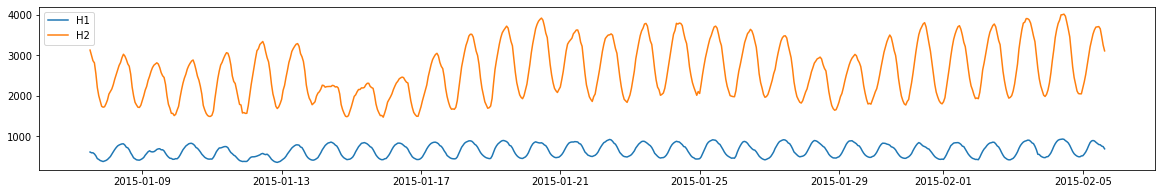

In [12]:
plt.figure(figsize=(20, 3))
for item_id in ["H1", "H2"]:
    plt.plot(ts_dataframe.loc[item_id], label=item_id)
plt.legend();

In [13]:
prediction_length = 48

test_data = ts_dataframe  # the full data set

# last prediction_length timesteps of each time series are excluded, akin to `x[:-48]`
train_data = ts_dataframe.slice_by_timestep(None, -prediction_length)


In [14]:
predictor = TimeSeriesPredictor(
    path="autogluon-m4-hourly",
    target="Value",
    prediction_length=prediction_length,
    eval_metric="MAPE",
)

predictor.fit(
    train_data,
    presets="medium_quality",
    time_limit=600,
)

================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Setting presets to: medium_quality
Fitting with arguments:
{'enable_ensemble': True,
 'evaluation_metric': 'MAPE',
 'hyperparameter_tune_kwargs': None,
 'hyperparameters': 'medium_quality',
 'prediction_length': 48,
 'random_seed': None,
 'target': 'Value',
 'time_limit': 600}
Provided training data set with 333628 rows, 414 items (item = single time series). Average time series length is 805.9.
Training artifacts will be saved to: /content/autogluon-m4-hourly
AutoGluon will save models to autogluon-m4-hourly/
AutoGluon will gauge predictive performance using evaluation metric: 'MAPE'
	This metric's sign has been flipped to adhere to being 'higher is better'. The reported score can be multiplied by -1 to get the metric value.
tuning_data is None. Will use the last prediction_length = 48 time steps of each time series as a hold-out validation set.

Starting training. Start time is 2022-11-25 16:02:28


In [16]:
predictor.leaderboard(test_data, silent=True)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  w

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,SeasonalNaive,-0.203127,-0.192171,2.327667,5.480913,0.018590,2
1,Theta,-0.294153,-0.213616,171.415992,166.113297,0.005965,4
2,Naive,-0.376335,-0.371842,2.116091,5.931639,0.047641,1
3,ETS,-0.397407,-0.346710,541.100475,548.433702,0.025103,3


In [17]:
predictions = predictor.predict(train_data)
predictions.head()

INFO:pytorch_lightning.utilities.seed:Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: SeasonalNaive


mean         0.1       0.2         0.3  \
item_id timestamp                                                      
H1      2015-02-03 16:00:00  594.0  515.624805  542.5294  561.929505   
        2015-02-03 17:00:00  528.0  449.624805  476.5294  495.929505   
        2015-02-03 18:00:00  474.0  395.624805  422.5294  441.929505   
        2015-02-03 19:00:00  447.0  368.624805  395.5294  414.929505   
        2015-02-03 20:00:00  423.0  344.624805  371.5294  390.929505   

                                   0.4    0.5        0.6         0.7  \
item_id timestamp                                                      
H1      2015-02-03 16:00:00  578.50618  594.0  609.49382  626.070495   
        2015-02-03 17:00:00  512.50618  528.0  543.49382  560.070495   
        2015-02-03 18:00:00  458.50618  474.0  489.49382  506.070495   
        2015-02-03 19:00:00  431.50618  447.0  462.49382  479.070495   
        2015-02-03 20:00:00  407.50618  423.0  438.49382  455.070495   

                                  0.8         0.9  
item_id timestamp                                  
H1      2015-02-03 16:00:00  645.4706  672.375195  
        2015-02-03 17:00:00  579.4706  606.375195  
        2015-02-03 18:00:00  525.4706  552.375195  
        2015-02-03 19:00:00  498.4706  525.375195  
        2015-02-03 20:00:00  474.4706  501.375195

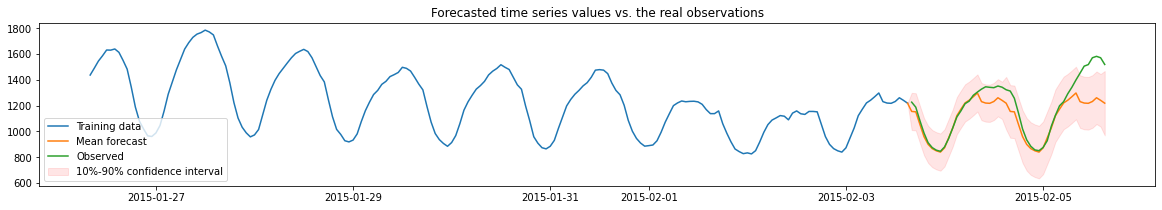

In [18]:
plt.figure(figsize=(20, 3))

item_id = "H3"
y_past = train_data.loc[item_id]["Value"]
y_pred = predictions.loc[item_id]
y_true = test_data.loc[item_id]["Value"][-prediction_length:]

# prepend the last value of true range to predicted range for plotting continuity
y_pred.loc[y_past.index[-1]] = [y_past[-1]] * 10
y_pred = y_pred.sort_index()

plt.plot(y_past[-200:], label="Training data")
plt.plot(y_pred["mean"], label="Mean forecast")
plt.plot(y_true, label="Observed")

plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
)
plt.title("Forecasted time series values vs. the real observations")
plt.legend();

In [20]:
print("this is the end")

hold
